In [ ]:
from bs4 import BeautifulSoup
import urllib.request
from urllib.parse import urljoin
from urllib.parse import urlparse
import re
import requests
import pandas as pd
import numpy as np
import io
import os
from dotenv import load_dotenv
import itertools
import random

: 

# Get all the data from the Human Mortality Database

The following code will get all life tables for women, men, and both sexes combined for all countries available

In [2]:

def get_HMD_codes():
    
    myLinks = []
    myLinksShort = []

    html_page = urllib.request.urlopen("https://mortality.org/Data/DataAvailability")
    soup = BeautifulSoup(html_page, "html.parser")
    for link in soup.find_all('a', attrs={'href': re.compile("=")}):
        myLinks.append(link.get("href"))
    for i in range(len(myLinks)):
        myLinksShort.append(myLinks[i].split("=")[1])
    out = [x.strip(' ') for x in myLinksShort]
    return out

codes = get_HMD_codes()
print(codes)

['AUS', 'AUT', 'BLR', 'BEL', 'BGR', 'CAN', 'CHL', 'HRV', 'CZE', 'DNK', 'EST', 'FIN', 'FRATNP', 'FRACNP', 'DEUTNP', 'DEUTE', 'DEUTW', 'GRC', 'HKG', 'HUN', 'ISL', 'IRL', 'ISR', 'ITA', 'JPN', 'LVA', 'LTU', 'LUX', 'NLD', 'NZL_NP', 'NZL_MA', 'NZL_NM', 'NOR', 'POL', 'PRT', 'KOR', 'RUS', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'TWN', 'GBR_NP', 'GBRTENW', 'GBRCENW', 'GBR_SCO', 'GBR_NIR', 'USA', 'UKR']


# Download function for HMD data

An account with username and password is required. Store this information in your .env file under "MY_USERNAME" and "MY_PASSWORD".

In [39]:
# Load environment variables from .env file
load_dotenv()

username = os.getenv("MY_USERNAME")
password = os.getenv("MY_PASSWORD")
     
def get_LT_HMD(username, password, country_code):

    url_start = "https://www.mortality.org/File/GetDocument/hmd.v6/"
    LT_women = url_start + country_code + "/STATS/fltper_1x1.txt"
    LT_men = url_start + country_code + "/STATS/mltper_1x1.txt"
    LT_both = url_start + country_code + "/STATS/bltper_1x1.txt"
    loginurl = 'https://www.mortality.org/Account/Login'
    payload = {            
        'ReturnUrl': 'https://www.mortality.org/Home/Index',
        'Email': str(username),
        'Password': str(password)
        }
    
    with requests.Session() as sess:
            res = sess.get(loginurl)
            signin = BeautifulSoup(res._content, 'html.parser')
            the_tok = signin.find('input', {'name': '__RequestVerificationToken'})['value']
            payload['__RequestVerificationToken'] = the_tok
            r = sess.post(loginurl, data = payload)
            LT_women_dat = sess.get(LT_women, allow_redirects=False)
            LT_men_dat = sess.get(LT_men, allow_redirects=False)
            LT_both_dat = sess.get(LT_both, allow_redirects=False)
            
            df_women = pd.read_csv(io.BytesIO(LT_women_dat.content), sep="\s+", skiprows=2)
            df_women.insert(0, "Country", country_code)
            df_women.insert(1, "Sex", "Women")
            df_men = pd.read_csv(io.BytesIO(LT_men_dat.content), sep="\s+", skiprows=2)
            df_men.insert(0, "Country", country_code)
            df_men.insert(1, "Sex", "Men")
            df_both = pd.read_csv(io.BytesIO(LT_both_dat.content), sep="\s+", skiprows=2)
            df_both.insert(0, "Country", country_code)
            df_both.insert(1, "Sex", "Both")
            df_all = pd.concat([df_women, df_men, df_both], ignore_index=True)
    
    return df_all


In [125]:
HMD_data_files = [get_LT_HMD(username=username, password=password, country_code=code) for code in codes]

HMD_LTs = pd.concat(HMD_data_files, ignore_index=True)
HMD_LTs.head()

,Country,Sex,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
0,AUS,Women,1921,0,0.05999,0.0575,0.28,100000,5750,95857,6317561,63.18
1,AUS,Women,1921,1,0.01206,0.01199,0.5,94250,1130,93685,6221704,66.01
2,AUS,Women,1921,2,0.00578,0.00576,0.5,93120,537,92851,6128020,65.81
3,AUS,Women,1921,3,0.00289,0.00288,0.5,92583,267,92450,6035168,65.19
4,AUS,Women,1921,4,0.00325,0.00325,0.5,92316,300,92166,5942719,64.37


In [2]:
#HMD_LTs.to_csv("HMD_LTs.csv", sep=";")
cols_as_str = [5, 6, 7, 8, 9, 10, 11, 12]
HMD_LTs = pd.read_csv("HMD_LTs.csv", sep= ";", dtype={col: "string" for col in cols_as_str})

# Dealing with incomplete data

There are some years with incomplete data. The following code removes those years from the dataframe.

In [3]:
HMD_LTs["qx"] = pd.to_numeric(HMD_LTs["qx"], errors='coerce')
HMD_LTs = HMD_LTs.dropna(subset=["qx"])

valid_years = (
    HMD_LTs.groupby("Year")["qx"]
    .apply(lambda x: not x.isna().any())   # exclude years with no qx values
)

valid_years = valid_years[valid_years].index
HMD_LTs = HMD_LTs[HMD_LTs["Year"].isin(valid_years)]
HMD_LTs["ex"] = pd.to_numeric(HMD_LTs["ex"], errors='coerce')

# Functions for analysis

The function calculates the survivorship functions from qx. It will calculate the difference in $e_0$ and get the Wasserstein distance for the same pair of populations.
To avoid negative values, it always calculates the difference in $e_0$ by substracting the smaller value from the larger one. The function will also check whether the condition $l_A(x) >= l_B(x)$ for all $x$ holds for the pair.
Finally, it will return the two county names, the year, sex, condition (True or False), $e_0$ difference, as well as the Wasserstein distance as a pandas dataframe.

In [50]:
from scipy.stats import entropy

def get_dx(df):
    """Get age-at-death probability distribution dx from lifetable"""
    qx = pd.to_numeric(df["qx"], errors='coerce').values
    if np.any(np.isnan(qx)):
        raise ValueError("NA in qx!")
    lx = np.concatenate(([1], np.cumprod(1 - qx)[:-1]))
    dx = np.concatenate((-np.diff(lx), [lx[-1]]))
    dx = dx / dx.sum()  # normalize to sum to 1 (just in case of rounding issues)
    return dx

def get_KL_divergence(dx1, dx2):
    """Get Kullback-Leibler divergence KL"""
    # add epsilon to avoid log(0)
    eps = 1e-12
    dx1_safe = np.clip(dx1, eps, 1)
    dx2_safe = np.clip(dx2, eps, 1)
    return float(entropy(dx1_safe, dx2_safe))

def get_Jaccard_distance(dx1, dx2):
    """Get Jaccard distance between two dx functions"""
    numerator = np.sum(np.minimum(dx1, dx2))
    denominator = np.sum(np.maximum(dx1, dx2))
    if denominator == 0:
        return 0.0
    jaccard_similarity = numerator / denominator
    return 1 - jaccard_similarity

def get_comparison_for_pair(HMD_LTs, year, sex, c1, c2):

    subset_df = HMD_LTs[(HMD_LTs["Sex"] == sex) & (HMD_LTs["Year"] == year)].copy()

    dx_dict = {}
    for country in [c1, c2]:
        country_df = subset_df[subset_df["Country"] == country]
        if country_df.empty:
            return None
        dx_dict[country] = get_dx(country_df)

    val1 = subset_df.loc[subset_df["Country"] == c1, "ex"].iloc[0]
    val2 = subset_df.loc[subset_df["Country"] == c2, "ex"].iloc[0]

    if val1 >= val2:
        countryA, countryB = c1, c2
    else:
        countryA, countryB = c2, c1

    dx1 = dx_dict[countryA]
    dx2 = dx_dict[countryB]

    # survival functions
    Sx1 = 1 - np.cumsum(dx1)
    Sx2 = 1 - np.cumsum(dx2)

    e0_1 = np.sum(Sx1) + 0.5
    e0_2 = np.sum(Sx2) + 0.5

    condition = "True" if np.all(Sx1 >= Sx2) else "False"
    Wasserstein = np.sum(np.abs(Sx1 - Sx2))
    e0_diff = np.sum(Sx1 - Sx2)

    KL_divergence = get_KL_divergence(dx1, dx2)
    Jaccard_distance = get_Jaccard_distance(dx1, dx2)

    return {
        "CountryA": countryA,
        "CountryB": countryB,
        "Year": year,
        "Sex": sex,
        "e_0_CountryA" : e0_1,
        "e_0_CountryB" : e0_2,
        "e0_Diff": round(e0_diff, 2),
        "Wasserstein": round(Wasserstein, 2),
        "KL_divergence": round(KL_divergence, 4),
        "Jaccard_distance": round(Jaccard_distance, 4),
        "Condition": condition
    }


# First analysis: Sample from all pairs

Calculating the two measures for all available pairs would take way too much time as they are many possible combinations (13 700 when considering only one gender). Instead, the following code will sample from the data. That is, it will generate random pairs.
Here, I focus only on data for both sexes combined. I sample 5 000 pairs from the data.

In [5]:
df_both = HMD_LTs[HMD_LTs["Sex"] == "Both"]
years = df_both["Year"].unique()

years = df_both["Year"].unique()
countries = df_both["Country"].unique()

num_pairs = len(years) * len(countries)
print(f"Total possible year-country combinations: {num_pairs}")

Total possible year-country combinations: 13700


In [62]:
results = []
pairs_sampled = 0
max_samples = 5000

while pairs_sampled < max_samples:

    year = random.choice(years)
    countries = df_both[df_both["Year"] == year]["Country"].unique()

    if len(countries) < 2:
        continue

    c1, c2 = random.sample(list(countries), 2)

    res = get_comparison_for_pair(HMD_LTs, year, "Both", c1, c2)
    
    if res is not None:
        results.append(res)
        pairs_sampled += 1

final_df = pd.DataFrame(results)
print(len(final_df))
final_df.head()

5000


,CountryA,CountryB,Year,Sex,e0_Diff,Wasserstein,KL_divergence,Jaccard_distance,Condition
0,AUS,PRT,1962,Both,6.59,6.59,0.0590,0.1764,False
1,IRL,GBR_SCO,2003,Both,1.75,1.76,0.0123,0.1214,False
2,GBRTENW,FRATNP,1861,Both,1.73,1.73,0.0114,0.1206,False
3,HKG,FRACNP,2023,Both,2.37,2.37,0.0422,0.1597,True
4,CHE,BEL,1906,Both,1.07,2.52,0.0193,0.1609,False


In [27]:
print(len(final_df))

5000


In [63]:
min_val_W1 = final_df["Wasserstein"].min()
max_val_W1 = final_df["Wasserstein"].max()
mean_val_W1 = final_df["Wasserstein"].mean()
print((round(min_val_W1,2), round(max_val_W1,2), round(mean_val_W1,2))) 

min_val_e0 = final_df["e0_Diff"].min()
max_val_e0 = final_df["e0_Diff"].max()
mean_val_e0 = final_df["e0_Diff"].mean()

print((round(min_val_e0,2), round(max_val_e0,2), round(mean_val_e0,2))) 

(np.float64(0.0), np.float64(30.42), np.float64(4.16))
(np.float64(0.0), np.float64(30.42), np.float64(3.93))


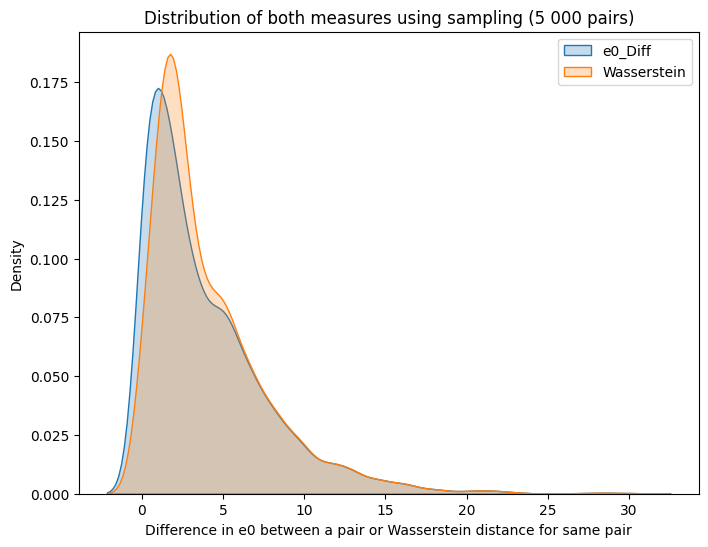

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

sns.kdeplot(final_df["e0_Diff"], label="e0_Diff", fill=True)
sns.kdeplot(final_df["Wasserstein"], label="Wasserstein", fill=True)

plt.title(f"Distribution of both measures using sampling (5 000 pairs)")
plt.xlabel("Difference in e0 between a pair or Wasserstein distance for same pair")
plt.legend()
plt.show()

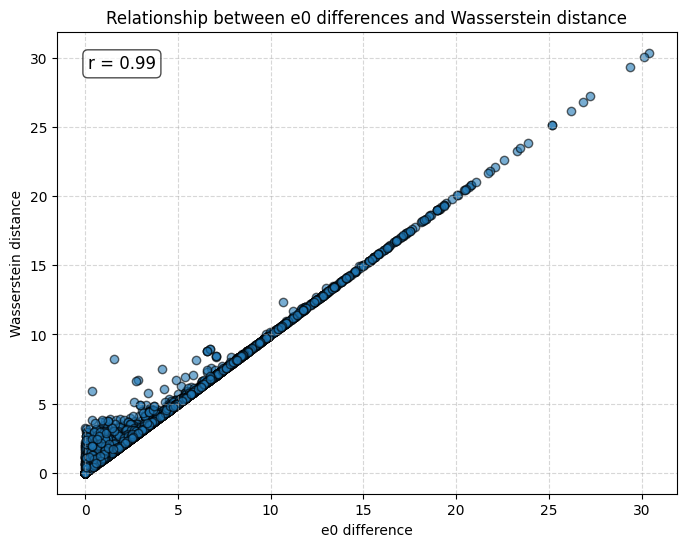

In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


# Calculate Pearson correlation coefficient
r, p_value = pearsonr(final_df["e0_Diff"], final_df["Wasserstein"])

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(final_df["e0_Diff"], final_df["Wasserstein"], alpha=0.6, edgecolor="k")

# Labels and title
plt.xlabel("e0 difference")
plt.ylabel("Wasserstein distance")
plt.title("Relationship between e0 differences and Wasserstein distance")

# Add grid
plt.grid(True, linestyle="--", alpha=0.5)

# Annotate Pearson r on plot
plt.text(
    0.05, 0.95, 
    f"r = {r:.2f}", 
    transform=plt.gca().transAxes,  # relative to axes
    fontsize=12, 
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.7)
)

plt.show()


In [10]:

r, p_value = pearsonr(final_df["e0_Diff"], final_df["Wasserstein"])

print(f"Pearson r: {r:.3f}")
print(f"P-value: {p_value:.3e}")

Pearson r: 0.993
P-value: 0.000e+00


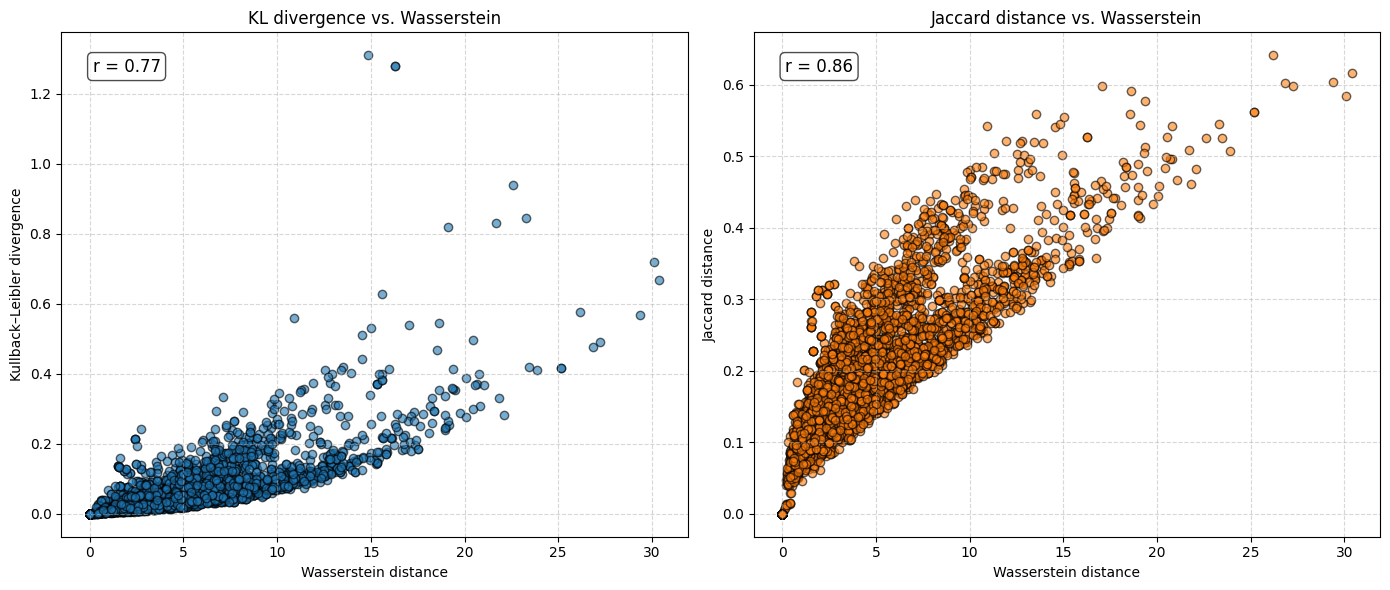

In [13]:
# Compute Pearson's r
r_kl, _ = pearsonr(final_df["Wasserstein"], final_df["KL_divergence"])
r_jaccard, _ = pearsonr(final_df["Wasserstein"], final_df["Jaccard_distance"])

# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

axes[0].scatter(final_df["Wasserstein"], final_df["KL_divergence"],
                alpha=0.6, edgecolor="k")
axes[0].set_xlabel("Wasserstein distance")
axes[0].set_ylabel("Kullback–Leibler divergence")
axes[0].set_title("KL divergence vs. Wasserstein")
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].text(0.05, 0.95, f"r = {r_kl:.2f}",
             transform=axes[0].transAxes, fontsize=12,
             verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

axes[1].scatter(final_df["Wasserstein"], final_df["Jaccard_distance"],
                alpha=0.6, edgecolor="k", color="tab:orange")
axes[1].set_xlabel("Wasserstein distance")
axes[1].set_ylabel("Jaccard distance")
axes[1].set_title("Jaccard distance vs. Wasserstein")
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].text(0.05, 0.95, f"r = {r_jaccard:.2f}",
             transform=axes[1].transAxes, fontsize=12,
             verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()


# Find the most interesting cases

In which pairs is the gap between $e_0$ differences and Wasserstein distance particulary large? What is the highest Wasserstein distance observed in the data? Where is the gap in $e_0$ largest and does the Wasserstein distance suggest large differences in the age-at-death distribution as well?

In [14]:
final_df["diff_abs"] = (final_df["e0_Diff"] - final_df["Wasserstein"]).abs()
threshold = final_df["diff_abs"].quantile(0.95)

interesting_cases = final_df[final_df["diff_abs"] >= threshold]
df_sorted = interesting_cases.sort_values(by='diff_abs', ascending=False)
print(df_sorted)

     CountryA CountryB  Year   Sex  e0_Diff  Wasserstein  KL_divergence  \
4347      PRT      FIN  1941  Both     1.58         8.20         0.2895   
2271      FIN      ISL  1894  Both     0.39         5.91         0.1806   
58        ISL      BEL  1849  Both     2.84         6.68         0.2420   
3817      PRT   NZL_MA  1959  Both     2.77         6.60         0.2071   
387    FRATNP      ESP  1917  Both     0.37         3.81         0.1640   
...       ...      ...   ...   ...      ...          ...            ...   
52        BEL  GBR_SCO  1902  Both     0.91         2.18         0.0206   
4518      NLD      CHE  1904  Both     1.64         2.89         0.0360   
4428      BLR  GBRCENW  1966  Both     1.72         2.97         0.0829   
2043      NLD      NOR  1932  Both     0.79         2.04         0.0238   
4384      DNK      ISL  1927  Both     3.10         4.35         0.0544   

      Jaccard_distance Condition  diff_abs  
4347            0.4468     False      6.62  
2271     

In [15]:
df_sorted2 = final_df.sort_values(by="Wasserstein", ascending=False)
df_sorted2.head()

,CountryA,CountryB,Year,Sex,e0_Diff,Wasserstein,KL_divergence,Jaccard_distance,Condition,diff_abs
2026,DNK,ITA,1918,Both,30.38,30.38,0.6677,0.6174,False,0.0
2527,NOR,ISL,1860,Both,30.10,30.10,0.7206,0.5844,True,0.0
3673,NOR,ISL,1882,Both,29.38,29.38,0.5693,0.6039,False,0.0
3305,GBR_SCO,ISL,1882,Both,27.23,27.23,0.4920,0.5980,False,0.0
4255,GBRCENW,ISL,1882,Both,26.84,26.84,0.4777,0.6031,False,0.0


In [16]:
df_sorted3 = final_df.sort_values(by="e0_Diff", ascending=False)
df_sorted3.head()

,CountryA,CountryB,Year,Sex,e0_Diff,Wasserstein,KL_divergence,Jaccard_distance,Condition,diff_abs
2026,DNK,ITA,1918,Both,30.38,30.38,0.6677,0.6174,False,0.0
2527,NOR,ISL,1860,Both,30.10,30.10,0.7206,0.5844,True,0.0
3673,NOR,ISL,1882,Both,29.38,29.38,0.5693,0.6039,False,0.0
3305,GBR_SCO,ISL,1882,Both,27.23,27.23,0.4920,0.5980,False,0.0
4255,GBRCENW,ISL,1882,Both,26.84,26.84,0.4777,0.6031,False,0.0


# Plot the most interesting cases

From all 10 000 samples, the largest gap between $e_0$ differences and Wasserstein distance is observed between Iceland and England and Wales in 1849 (6.2).
The largest Wasserstein distance is observed between Sweden and Iceland in 1860 with about 28.6. This is also the pair with the largest gap in $e_0$ in this sample.

In [65]:
def get_dx_for_plot(df, year):
    qx = df.loc[df["Year"] == year, "qx"].values
    lx = np.concatenate(([1], np.cumprod(1 - qx)[:-1]))
    dx = np.concatenate((-np.diff(lx), [lx[-1]]))
    return dx

def get_e0_for_plot(df, year):
    ex = df.loc[df["Year"] == year, "ex"].values
    e0 = ex[0]
    return e0

def get_Sx_for_plot(dx):
    CDF = np.cumsum(dx)
    Sx = 1 - CDF
    return Sx

def plot_dx(ages, dx1, dx2, e0_1, e0_2, label1, label2):
    plt.figure(figsize=(8, 6))
    plt.plot(ages, dx1, label=f"{label1} (e₀ = {e0_1:.1f})", marker='o')
    plt.plot(ages, dx2, label=f"{label2} (e₀ = {e0_2:.1f})", marker='s')
    plt.text(ages[np.argmax(dx1)]-10, max(dx1), f"e₀ = {e0_1:.1f}", fontsize=10, ha='left', va='bottom')
    plt.text(ages[np.argmax(dx2)]-10, max(dx2), f"e₀ = {e0_2:.1f}", fontsize=10, ha='left', va='bottom')
    plt.title("Comparison of Death Distributions by Age")
    plt.xlabel("Age")
    plt.ylabel("dx (number of deaths)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_Sx(ages, Sx1, Sx2, label1, label2):
    plt.figure(figsize=(8, 6))
    plt.plot(ages, Sx1, label=f"{label1}", marker='o')
    plt.plot(ages, Sx2, label=f"{label2}", marker='s')
    plt.fill_between(ages, Sx1, Sx2, color='gray', alpha=0.4)
    plt.title("Comparison of survivorship functions")
    plt.xlabel("Age")
    plt.ylabel("Proportion of being alive")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [55]:
the_year = 1849

pair1 = HMD_LTs[(HMD_LTs['Year'] == the_year) & 
               (HMD_LTs['Sex'] == "Both") & 
               (HMD_LTs['Country'] == "GBRTENW")]

dx1 = get_dx_for_plot(pair1, the_year)
e0_1 = get_e0_for_plot(pair1, the_year)

pair2 = HMD_LTs[(HMD_LTs['Year'] == the_year) & 
               (HMD_LTs['Sex'] == "Both") & 
               (HMD_LTs['Country'] == "ISL")]

dx2 = get_dx_for_plot(pair2, the_year)
e0_2 = get_e0_for_plot(pair2, the_year)

Sx1 = get_Sx_for_plot(dx1)
Sx2 = get_Sx_for_plot(dx2)

ages = np.arange(len(dx1))


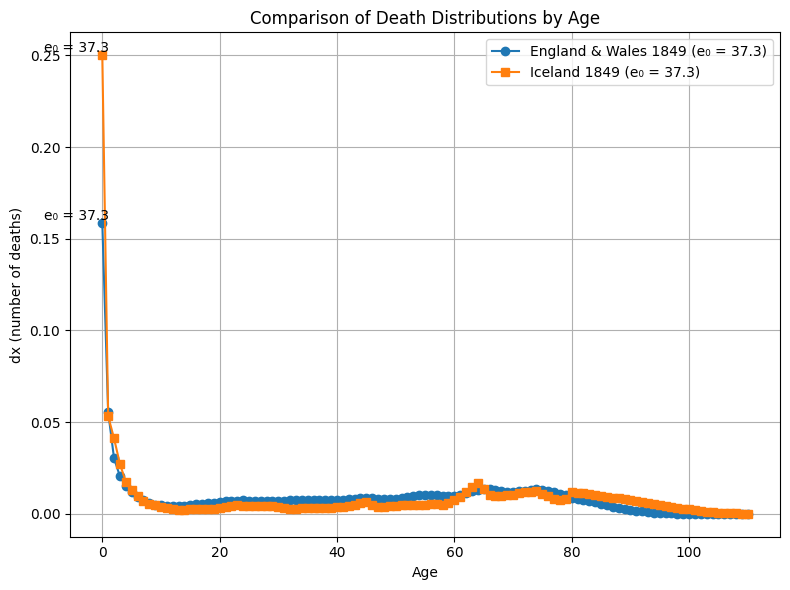

In [56]:
plot_dx(ages, dx1, dx2, e0_1, e0_2, "England & Wales 1849", "Iceland 1849")

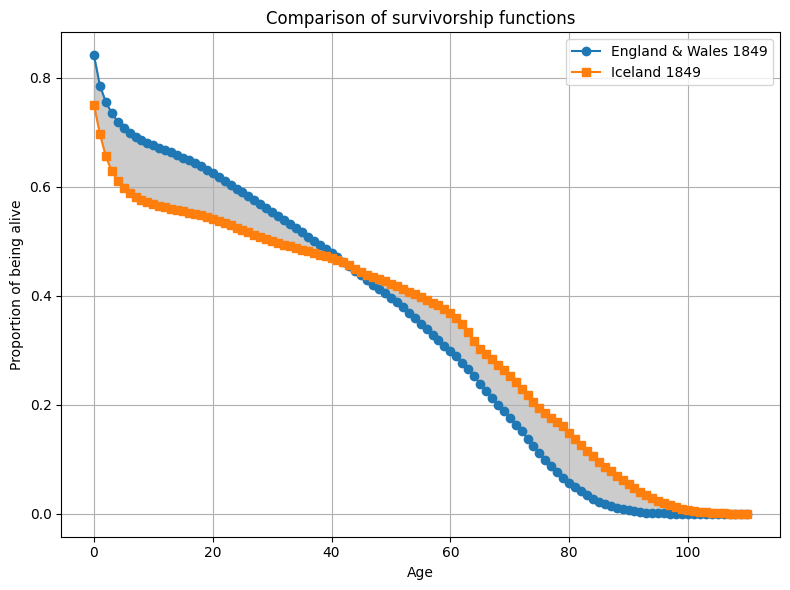

In [57]:
plot_Sx(ages, Sx1, Sx2, "England & Wales 1849", "Iceland 1849")

In [58]:
the_year = 1918

pair1 = HMD_LTs[(HMD_LTs['Year'] == the_year) & 
               (HMD_LTs['Sex'] == "Both") & 
               (HMD_LTs['Country'] == "DNK")]

dx1 = get_dx_for_plot(pair1, the_year)
e0_1 = get_e0_for_plot(pair1, the_year)

pair2 = HMD_LTs[(HMD_LTs['Year'] == the_year) & 
               (HMD_LTs['Sex'] == "Both") & 
               (HMD_LTs['Country'] == "ITA")]

dx2 = get_dx_for_plot(pair2, the_year)
e0_2 = get_e0_for_plot(pair2, the_year)

Sx1 = get_Sx_for_plot(dx1)
Sx2 = get_Sx_for_plot(dx2)

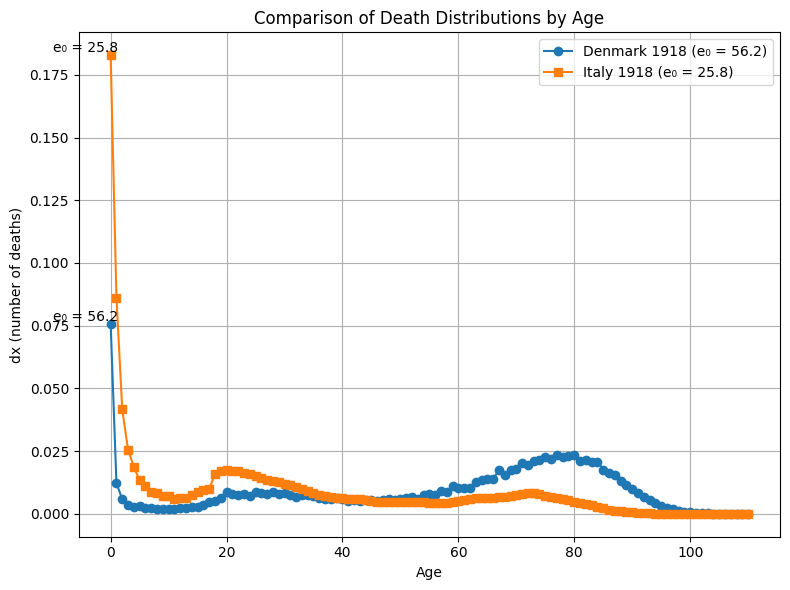

In [59]:
plot_dx(ages, dx1, dx2, e0_1, e0_2, "Denmark 1918", "Italy 1918")

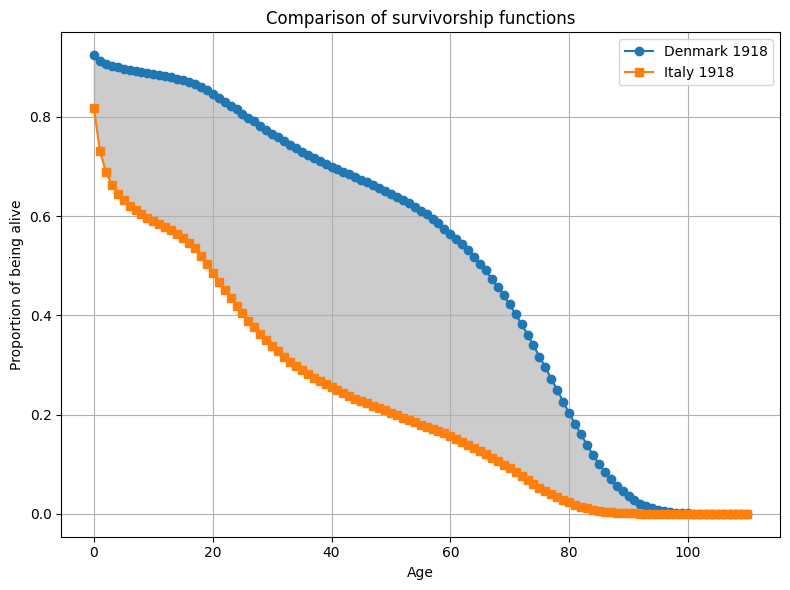

In [60]:
plot_Sx(ages, Sx1, Sx2, "Denmark 1918", "Italy 1918")

# Second analysis: What about more recent years?

Let's focus only on the last decades and examine the relationship observed between 1990 and 2020. This time we do not sample but calculate all possible combinations.

In [15]:
def get_comparison(HMD_LTs, year, sex):
    subset_df = HMD_LTs[(HMD_LTs["Sex"] == sex) & (HMD_LTs["Year"] == year)].copy()
    countries = subset_df["Country"].unique()

    # Store dx (age-at-death distributions)
    dx_dict = {}
    for country in countries:
        country_df = subset_df[subset_df["Country"] == country]
        if country_df.empty:
            continue
        dx_dict[country] = get_dx(country_df)

    # All country pairs
    country_pairs = list(itertools.combinations(countries, 2))

    results = []
    for c1, c2 in country_pairs:
        val1 = subset_df.loc[subset_df["Country"] == c1, "ex"].iloc[0]
        val2 = subset_df.loc[subset_df["Country"] == c2, "ex"].iloc[0]

        # Define CountryA (higher life expectancy) and CountryB
        if val1 >= val2:
            countryA, countryB = c1, c2
        else:
            countryA, countryB = c2, c1

        dx1 = dx_dict[countryA]
        dx2 = dx_dict[countryB]

        # Get survival functions
        Sx1 = 1 - np.cumsum(dx1)
        Sx2 = 1 - np.cumsum(dx2)

        # Condition check
        condition = "True" if np.all(Sx1 >= Sx2) else "False"

        # Distances
        Wasserstein = np.sum(np.abs(Sx1 - Sx2))
        e0_diff = np.sum(Sx1 - Sx2)
        KL_divergence = get_KL_divergence(dx1, dx2)
        Jaccard_distance = get_Jaccard_distance(dx1, dx2)

        results.append({
            "CountryA": countryA,
            "CountryB": countryB,
            "Year": year,
            "Sex": sex,
            "e0_Diff": round(e0_diff, 2),
            "Wasserstein": round(Wasserstein, 2),
            "KL_divergence": round(KL_divergence, 4),
            "Jaccard_distance": round(Jaccard_distance, 4),
            "Condition": condition
        })

    diff_df = pd.DataFrame(results)
    return diff_df

In [29]:
all_results = []

for sex in ["Women", "Men"]:
    for year in range(1990, 2021):
        df_diff = get_comparison(HMD_LTs, year, sex)
        if df_diff is not None and not df_diff.empty:
            all_results.append(df_diff)

final_df = pd.concat(all_results, ignore_index=True)
len(final_df)

68948

In [43]:
print(len(final_df["Wasserstein"]))
final_df.head()

68948


,CountryA,CountryB,Year,Sex,e0_Diff,Wasserstein,KL_divergence,Jaccard_distance,Condition,Diff_e0_Wasserstein
0,AUS,AUT,1990,Women,1.28,1.31,0.0266,0.1427,False,0.03
1,AUS,BLR,1990,Women,4.36,4.36,0.0683,0.2652,False,0.00
2,AUS,BEL,1990,Women,0.82,0.82,0.0100,0.0885,False,0.00
3,AUS,BGR,1990,Women,5.34,5.34,0.1651,0.3374,False,0.00
4,CAN,AUS,1990,Women,0.48,0.57,0.0052,0.0675,False,0.09


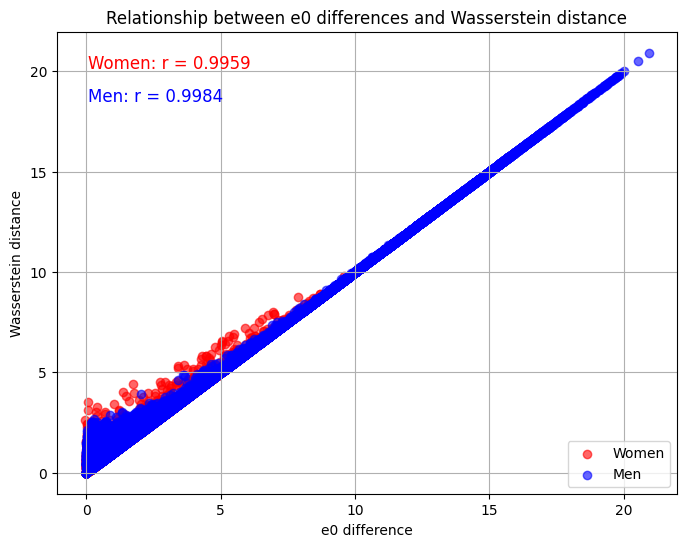

In [ ]:
plt.figure(figsize=(8,6))

for sex, color in zip(["Women", "Men"], ["red", "blue"]):
    subset = final_df[final_df["Sex"] == sex]
    plt.scatter(subset["e0_Diff"], subset["Wasserstein"], alpha=0.6, label=sex, color=color)
    
    r, _ = pearsonr(subset["e0_Diff"], subset["Wasserstein"])
    
    plt.text(
        0.05, 
        0.95 - (0.07 if sex == "Men" else 0), 
        f"{sex}: r = {r:.4f}", 
        transform=plt.gca().transAxes,
        fontsize=12,
        color=color,
        verticalalignment="top"
    )

plt.xlabel("e0 difference")
plt.ylabel("Wasserstein distance")
plt.title("Relationship between e0 differences and Wasserstein distance")
plt.legend()
plt.grid(True)
plt.show()

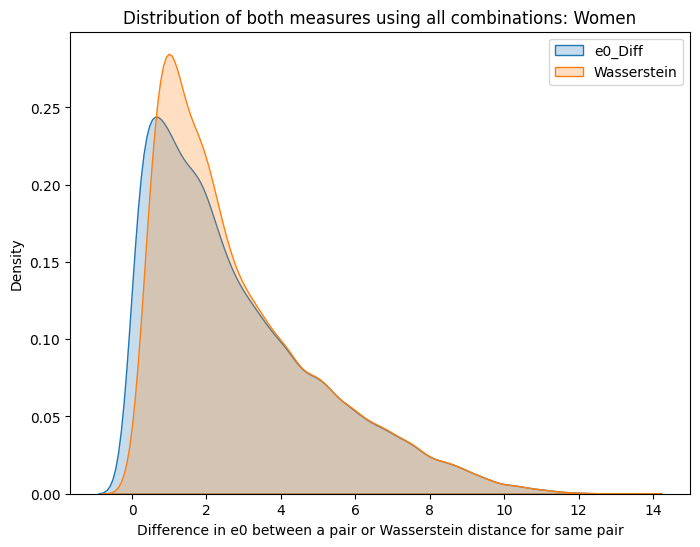

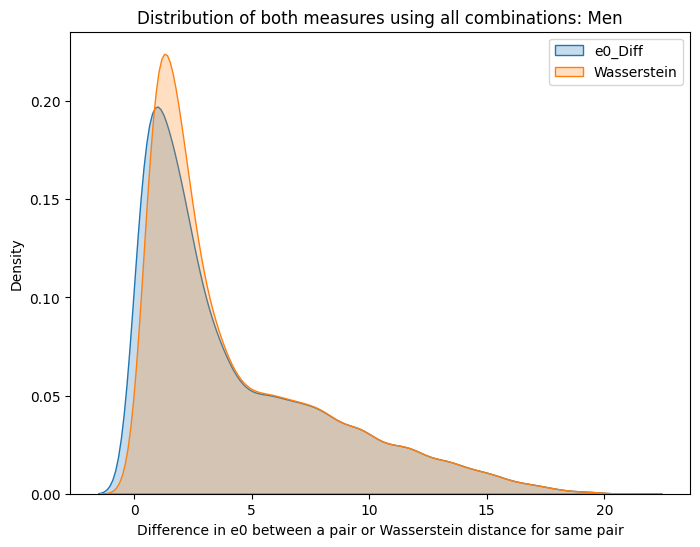

In [61]:
for sex in ["Women", "Men"]:
    subset = final_df[final_df["Sex"] == sex]
    plt.figure(figsize=(8,6))

    sns.kdeplot(subset["e0_Diff"], label="e0_Diff", fill=True)
    sns.kdeplot(subset["Wasserstein"], label="Wasserstein", fill=True)

    plt.title(f"Distribution of both measures using all combinations: {sex}")
    plt.xlabel("Difference in e0 between a pair or Wasserstein distance for same pair")
    plt.legend()
    plt.show()

In [39]:
summary = (
    final_df
    .groupby("Sex")[["Wasserstein", "e0_Diff"]]
    .agg(["min", "mean", "max"])
    .round(2)
)


summary.columns = [f"{col}_{stat}" for col, stat in summary.columns]
print(summary.reset_index())

     Sex  Wasserstein_min  Wasserstein_mean  Wasserstein_max  e0_Diff_min  \
0    Men              0.0              4.45            20.93        -0.01   
1  Women              0.0              2.92            13.38        -0.05   

   e0_Diff_mean  e0_Diff_max  
0          4.33        20.93  
1          2.81        13.38  


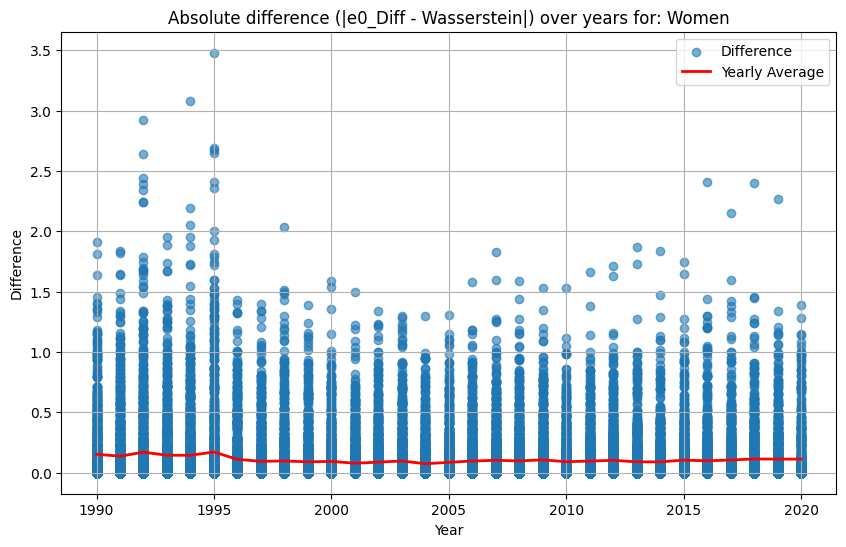

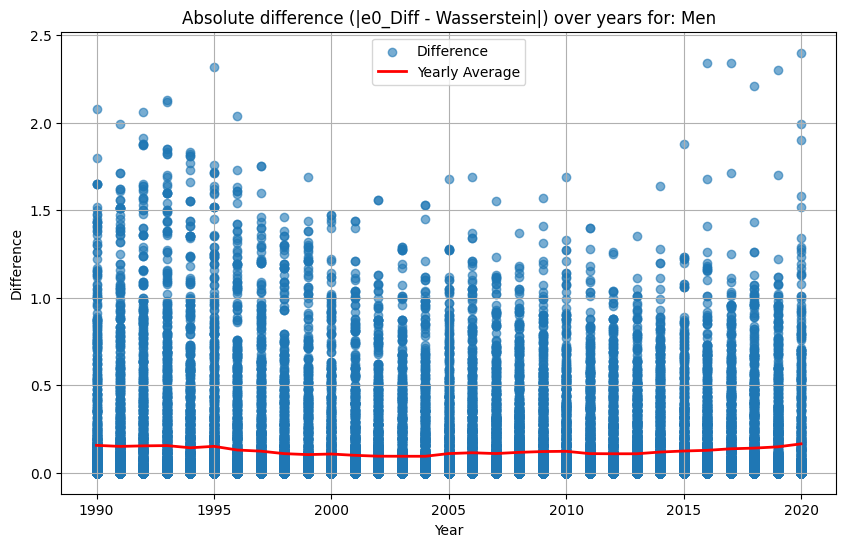

In [40]:
final_df["e0_Diff"] = pd.to_numeric(final_df["e0_Diff"], errors='coerce')
final_df["Wasserstein"] = pd.to_numeric(final_df["Wasserstein"], errors='coerce')

final_df["Diff_e0_Wasserstein"] = abs(final_df["e0_Diff"] - final_df["Wasserstein"])

for sex in ["Women", "Men"]:
    df_sex = final_df[final_df["Sex"] == sex]

    yearly_avg = df_sex.groupby("Year")["Diff_e0_Wasserstein"].mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.scatter(df_sex["Year"], df_sex["Diff_e0_Wasserstein"], alpha=0.6, label="Difference")
    plt.plot(yearly_avg["Year"], yearly_avg["Diff_e0_Wasserstein"], color="red", linewidth=2, label="Yearly Average")
    plt.title(f"Absolute difference (|e0_Diff - Wasserstein|) over years for: {sex}")
    plt.xlabel("Year")
    plt.ylabel("Difference")
    plt.grid(True)
    plt.legend()
    plt.show()


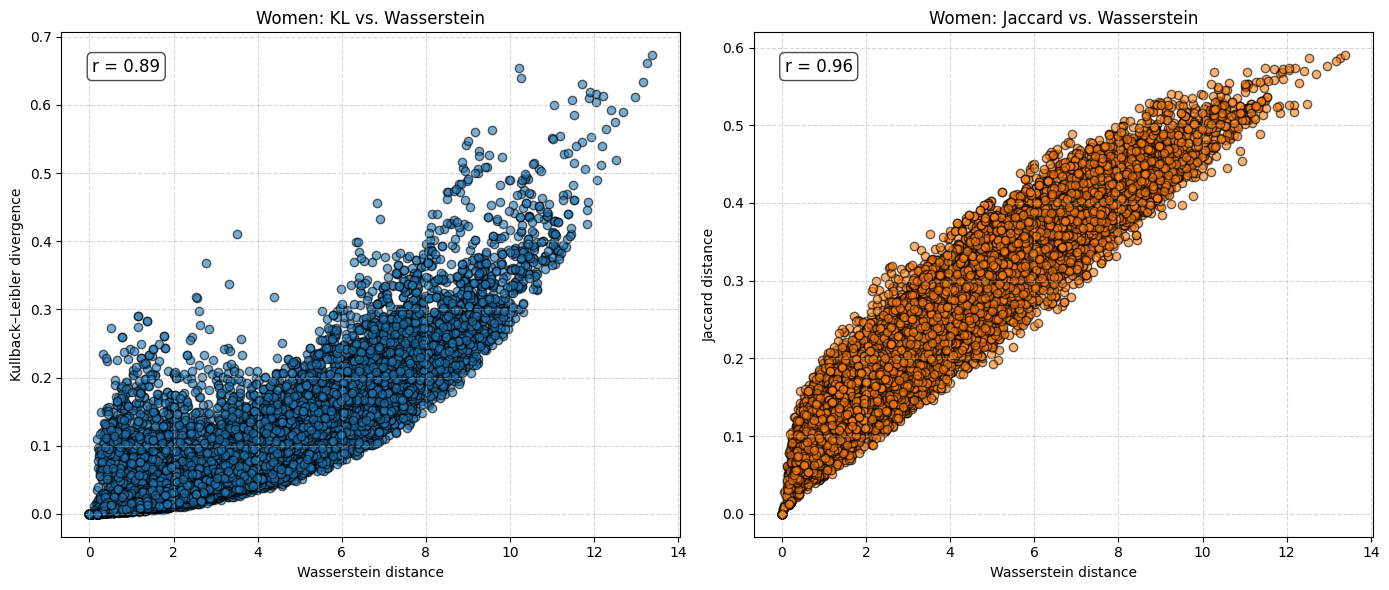

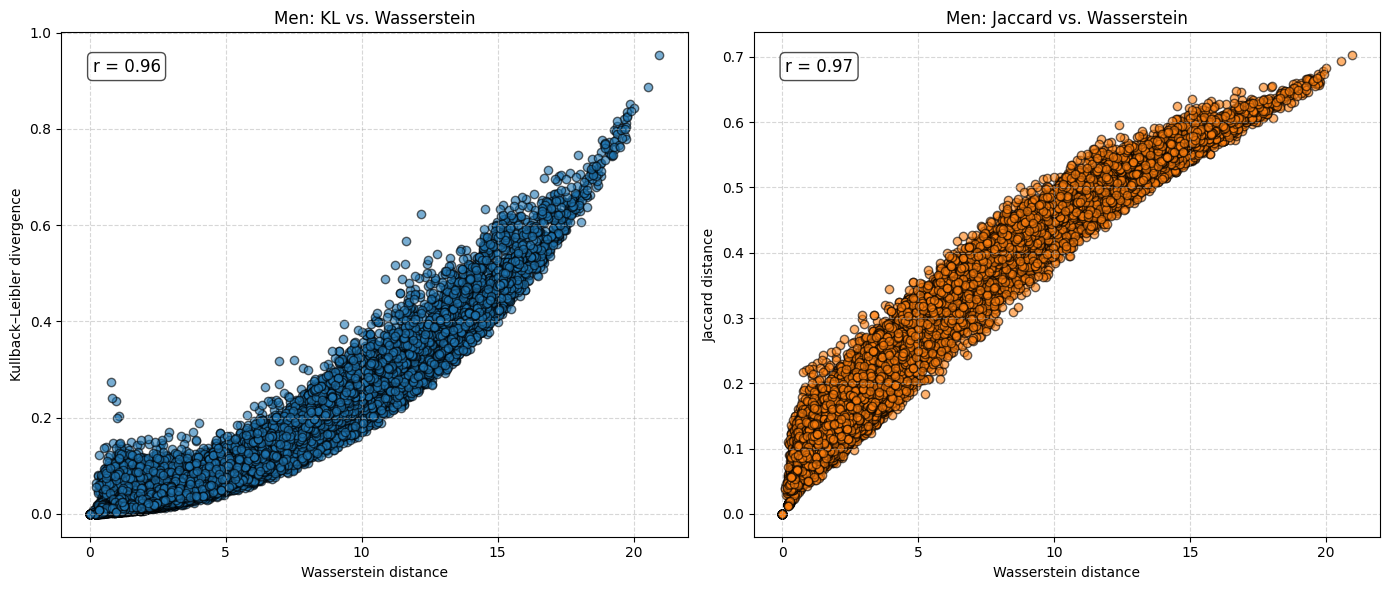

In [41]:
# Loop over sexes
for sex in ["Women", "Men"]:
    df_sex = final_df[final_df["Sex"] == sex]
    if df_sex.empty:
        continue

    # Pearson correlations
    r_kl, _ = pearsonr(df_sex["Wasserstein"], df_sex["KL_divergence"])
    r_jaccard, _ = pearsonr(df_sex["Wasserstein"], df_sex["Jaccard_distance"])

    # Make two side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Plot 1: KL vs Wasserstein ---
    axes[0].scatter(df_sex["Wasserstein"], df_sex["KL_divergence"],
                    alpha=0.6, edgecolor="k")
    axes[0].set_xlabel("Wasserstein distance")
    axes[0].set_ylabel("Kullback–Leibler divergence")
    axes[0].set_title(f"{sex}: KL vs. Wasserstein")
    axes[0].grid(True, linestyle="--", alpha=0.5)
    axes[0].text(0.05, 0.95, f"r = {r_kl:.2f}",
                 transform=axes[0].transAxes,
                 fontsize=12, verticalalignment="top",
                 bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # --- Plot 2: Jaccard vs Wasserstein ---
    axes[1].scatter(df_sex["Wasserstein"], df_sex["Jaccard_distance"],
                    alpha=0.6, edgecolor="k", color="tab:orange")
    axes[1].set_xlabel("Wasserstein distance")
    axes[1].set_ylabel("Jaccard distance")
    axes[1].set_title(f"{sex}: Jaccard vs. Wasserstein")
    axes[1].grid(True, linestyle="--", alpha=0.5)
    axes[1].text(0.05, 0.95, f"r = {r_jaccard:.2f}",
                 transform=axes[1].transAxes,
                 fontsize=12, verticalalignment="top",
                 bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    plt.tight_layout()
    plt.show()

# Third analysis: Investigating sex differences in mortality using the Wasserstein distance

Since women usually outlive men it might be interesting to compare differences between women and men on the basis of the Wasserstein distance.

In [65]:
def get_comparison_sex_diff(HMD_LTs, year):
    subset_df = HMD_LTs[HMD_LTs["Year"] == year].copy()
    countries = subset_df["Country"].unique()
    results = []

    for country in countries:
        women_df = subset_df[(subset_df["Country"] == country) & (subset_df["Sex"] == "Women")]
        men_df = subset_df[(subset_df["Country"] == country) & (subset_df["Sex"] == "Men")]

        if women_df.empty or men_df.empty:
            continue

        # Get dx distributions
        dx_women = get_dx(women_df)
        dx_men = get_dx(men_df)

        # Survival functions (needed for Wasserstein + condition)
        Sx_women = 1 - np.cumsum(dx_women)
        Sx_men = 1 - np.cumsum(dx_men)

        # Condition check
        condition = "True" if np.all(Sx_women >= Sx_men) else "False"

        # Distances
        e0_diff = np.sum(Sx_women - Sx_men)
        wasserstein = np.sum(np.abs(Sx_women - Sx_men))
        KL_divergence = get_KL_divergence(dx_women, dx_men)
        Jaccard_distance = get_Jaccard_distance(dx_women, dx_men)

        results.append({
            "Country": country,
            "Year": year,
            "e0_Diff": round(e0_diff, 2),
            "Wasserstein": round(wasserstein, 2),
            "KL_divergence": round(KL_divergence, 4),
            "Jaccard_distance": round(Jaccard_distance, 4),
            "Condition": condition
        })

    diff_df = pd.DataFrame(results)
    return diff_df


In [66]:
all_results_sex_diff = []

for year in range(1990, 2021):
    df_diff = get_comparison_sex_diff(HMD_LTs, year) 
    if df_diff is not None and not df_diff.empty:
        all_results_sex_diff.append(df_diff)

final_df_sex_diff = pd.concat(all_results_sex_diff, ignore_index=True)

In [67]:
r, p_value = pearsonr(final_df_sex_diff["e0_Diff"], final_df_sex_diff["Wasserstein"])

print(f"Pearson r: {r:.3f}")
print(f"P-value: {p_value:.3e}")

Pearson r: 1.000
P-value: 0.000e+00


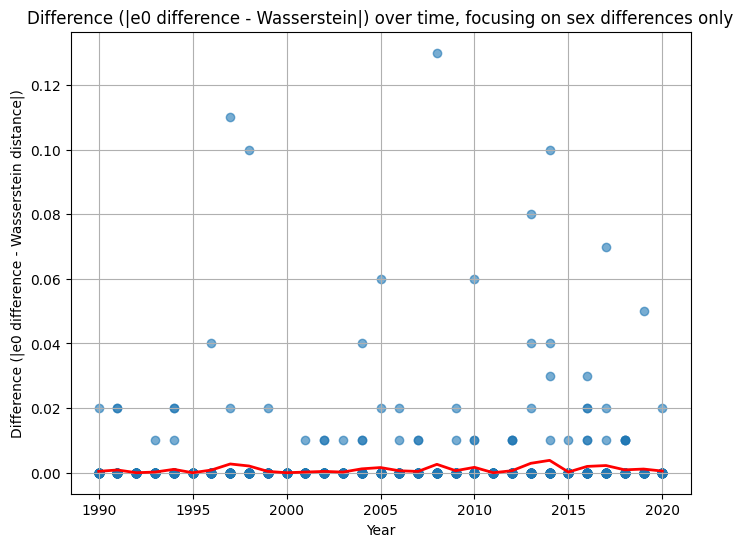

In [71]:
final_df_sex_diff["Diff_e0_Wasserstein"] = abs(final_df_sex_diff["e0_Diff"] - final_df_sex_diff["Wasserstein"])
yearly_avg = final_df_sex_diff.groupby("Year")["Diff_e0_Wasserstein"].mean().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(final_df_sex_diff["Year"], final_df_sex_diff["Diff_e0_Wasserstein"], alpha=0.6)
plt.plot(yearly_avg["Year"], yearly_avg["Diff_e0_Wasserstein"], color="red", linewidth=2, label="Yearly Average")
plt.title("Difference (|e0 difference - Wasserstein|) over time, focusing on sex differences only")
plt.xlabel("Year")
plt.ylabel("Difference (|e0 difference - Wasserstein distance|)")
plt.grid(True)
plt.show()

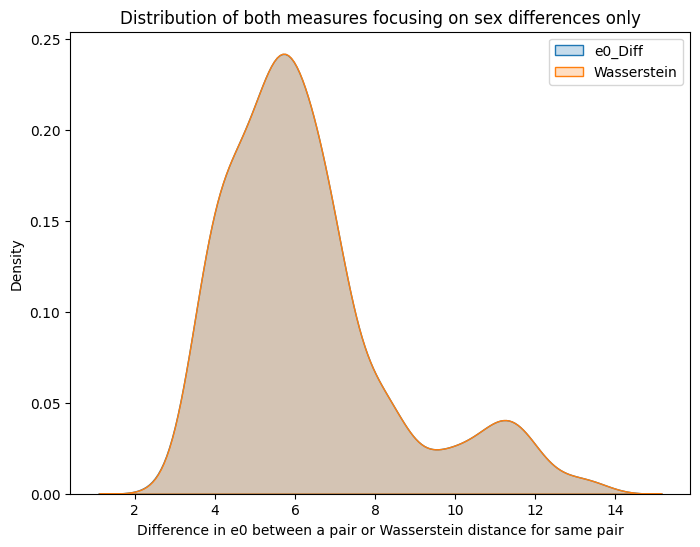

In [69]:
plt.figure(figsize=(8,6))

sns.kdeplot(final_df_sex_diff["e0_Diff"], label="e0_Diff", fill=True)
sns.kdeplot(final_df_sex_diff["Wasserstein"], label="Wasserstein", fill=True)

plt.title(f"Distribution of both measures focusing on sex differences only")
plt.xlabel("Difference in e0 between a pair or Wasserstein distance for same pair")
plt.legend()
plt.show()

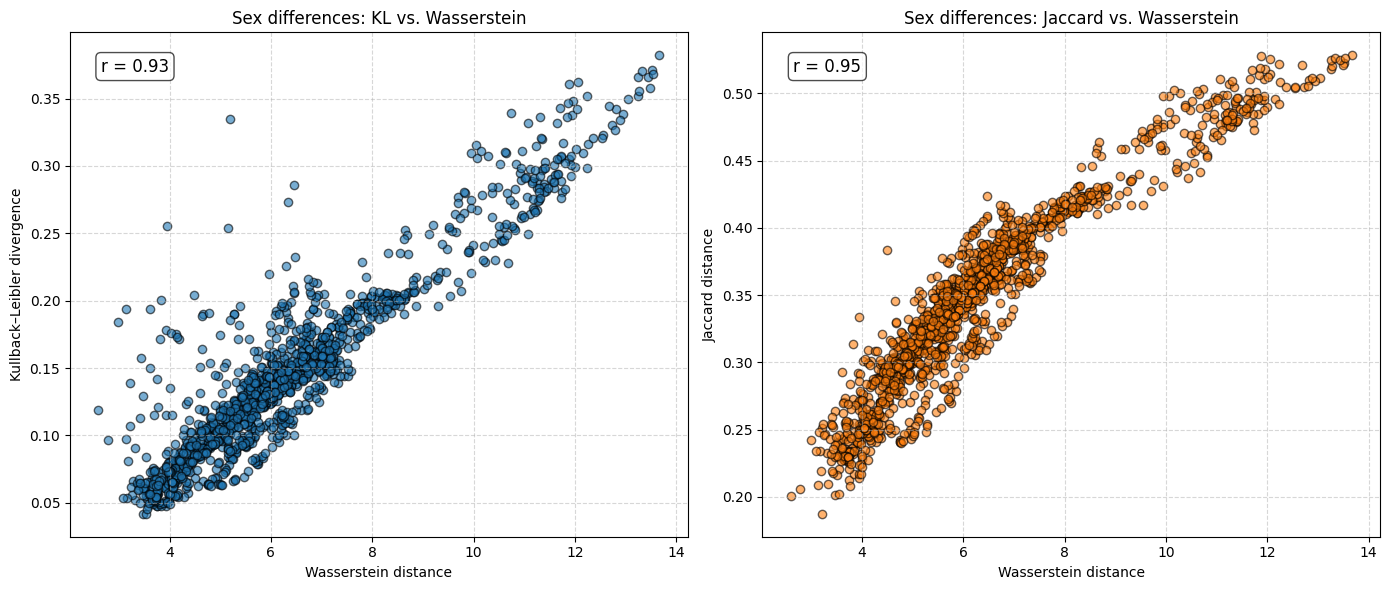

In [45]:
# Compute Pearson correlations
r_kl, _ = pearsonr(final_df_sex_diff["Wasserstein"], final_df_sex_diff["KL_divergence"])
r_jaccard, _ = pearsonr(final_df_sex_diff["Wasserstein"], final_df_sex_diff["Jaccard_distance"])

# Make two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: KL vs Wasserstein ---
axes[0].scatter(final_df_sex_diff["Wasserstein"], final_df_sex_diff["KL_divergence"],
                alpha=0.6, edgecolor="k")
axes[0].set_xlabel("Wasserstein distance")
axes[0].set_ylabel("Kullback–Leibler divergence")
axes[0].set_title("Sex differences: KL vs. Wasserstein")
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].text(0.05, 0.95, f"r = {r_kl:.2f}",
             transform=axes[0].transAxes, fontsize=12,
             verticalalignment="top",
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

# --- Plot 2: Jaccard vs Wasserstein ---
axes[1].scatter(final_df_sex_diff["Wasserstein"], final_df_sex_diff["Jaccard_distance"],
                alpha=0.6, edgecolor="k", color="tab:orange")
axes[1].set_xlabel("Wasserstein distance")
axes[1].set_ylabel("Jaccard distance")
axes[1].set_title("Sex differences: Jaccard vs. Wasserstein")
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].text(0.05, 0.95, f"r = {r_jaccard:.2f}",
             transform=axes[1].transAxes, fontsize=12,
             verticalalignment="top",
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

# Using cohort life tables instead of period life tables

In [53]:
# Load environment variables from .env file
load_dotenv()

username = os.getenv("MY_USERNAME")
password = os.getenv("MY_PASSWORD")
     
def get_cohort_LT_HMD(username, password, country_code):

    url_start = "https://www.mortality.org/File/GetDocument/hmd.v6/"
    LT_women = url_start + country_code + "/STATS/fltcoh_1x1.txt"
    LT_men = url_start + country_code + "/STATS/mltcoh_1x1.txt"
    LT_both = url_start + country_code + "/STATS/bltcoh_1x1.txt"
    loginurl = 'https://www.mortality.org/Account/Login'
    payload = {            
        'ReturnUrl': 'https://www.mortality.org/Home/Index',
        'Email': str(username),
        'Password': str(password)
        }
    
    with requests.Session() as sess:
            res = sess.get(loginurl)
            signin = BeautifulSoup(res._content, 'html.parser')
            the_tok = signin.find('input', {'name': '__RequestVerificationToken'})['value']
            payload['__RequestVerificationToken'] = the_tok
            r = sess.post(loginurl, data = payload)
            LT_women_dat = sess.get(LT_women, allow_redirects=False)
            LT_men_dat = sess.get(LT_men, allow_redirects=False)
            LT_both_dat = sess.get(LT_both, allow_redirects=False)
            
            df_women = pd.read_csv(io.BytesIO(LT_women_dat.content), sep="\s+", skiprows=2)
            df_women.insert(0, "Country", country_code)
            df_women.insert(1, "Sex", "Women")
            df_men = pd.read_csv(io.BytesIO(LT_men_dat.content), sep="\s+", skiprows=2)
            df_men.insert(0, "Country", country_code)
            df_men.insert(1, "Sex", "Men")
            df_both = pd.read_csv(io.BytesIO(LT_both_dat.content), sep="\s+", skiprows=2)
            df_both.insert(0, "Country", country_code)
            df_both.insert(1, "Sex", "Both")
            df_all = pd.concat([df_women, df_men, df_both], ignore_index=True)
    
    return df_all


In [54]:
cohort_codes = ["DNK", "FIN", "FRATNP", "ISL", "ITA", "NLD", "NOR", "ESP", "SWE", "CHE", "GBRTENW"]

cohort_HMD_data_files = [get_cohort_LT_HMD(username=username, password=password, country_code=code) for code in cohort_codes]

cohort_HMD_LTs = pd.concat(cohort_HMD_data_files, ignore_index=True)
cohort_HMD_LTs.head()

,Country,Sex,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
0,DNK,Women,1835,0,0.19374,0.17102,0.31,100000,17102,88270,4538017,45.38
1,DNK,Women,1835,1,0.04302,0.04205,0.46,82898,3486,81031,4449747,53.68
2,DNK,Women,1835,2,0.02762,0.02724,0.49,79413,2163,78320,4368716,55.01
3,DNK,Women,1835,3,0.01946,0.01928,0.51,77249,1489,76526,4290396,55.54
4,DNK,Women,1835,4,0.01376,0.01367,0.50,75760,1036,75246,4213870,55.62


In [55]:
# Replace "110+" with 110, cast to int
cohort_HMD_LTs["Age"] = cohort_HMD_LTs["Age"].replace("110+", 110)
cohort_HMD_LTs["Age"] = cohort_HMD_LTs["Age"].astype(int)

# Set qx=1 at age 100 (force everyone to die at 100)
cohort_HMD_LTs.loc[cohort_HMD_LTs["Age"] == 100, "qx"] = 1.0

cohort_HMD_LTs["qx"] = pd.to_numeric(cohort_HMD_LTs["qx"], errors='coerce')
cohort_HMD_LTs = cohort_HMD_LTs.dropna(subset=["qx"])

# Keep only ages 0 to 100
cohort_HMD_LTs = cohort_HMD_LTs[cohort_HMD_LTs["Age"].between(0, 100)]



valid_years = (
    cohort_HMD_LTs.groupby("Year")["qx"]
    .apply(lambda x: not x.isna().any())   # exclude years with no qx values
)

valid_years = valid_years[valid_years].index
cohort_HMD_LTs = cohort_HMD_LTs[cohort_HMD_LTs["Year"].isin(valid_years)]
cohort_HMD_LTs["ex"] = pd.to_numeric(cohort_HMD_LTs["ex"], errors='coerce')

In [56]:
cohort_HMD_LTs = cohort_HMD_LTs[cohort_HMD_LTs["Year"].between(1890, 1920)]
cohort_HMD_LTs.tail()
print(len(cohort_HMD_LTs))

97869


In [57]:
all_results = []

for sex in ["Women", "Men"]:

    combos = cohort_HMD_LTs.loc[cohort_HMD_LTs["Sex"] == sex, ["Year", "Country"]].drop_duplicates()

    for (y1, c1), (y2, c2) in itertools.combinations(combos.values, 2):
        res = get_comparison_for_pair(cohort_HMD_LTs, year=y1, sex=sex, c1=c1, c2=c2)
        if res is not None:
            
            res["YearA"] = y1
            res["YearB"] = y2
            all_results.append(res)

final_df_cohort = pd.DataFrame(all_results)

In [85]:
print(pair1.head())
pair2.head()

      Country  Sex  Year  Age       mx       qx    ax      lx     dx     Lx  \
42957     FIN  Men  1912    0  0.13207  0.12088  0.30  100000  12088  91527   
42958     FIN  Men  1912    1  0.03624  0.03556  0.47   87912   3126  86262   
42959     FIN  Men  1912    2  0.01800  0.01784  0.50   84786   1513  84024   
42960     FIN  Men  1912    3  0.01264  0.01256  0.52   83273   1046  82768   
42961     FIN  Men  1912    4  0.00955  0.00951  0.51   82227    782  81844   

            Tx     ex  
42957  4765391  47.65  
42958  4673864  53.17  
42959  4587602  54.11  
42960  4503578  54.08  
42961  4420811  53.76  


,Country,Sex,Year,Age,mx,qx,ax,lx,dx,Lx,Tx,ex
202131,ESP,Men,1916,0,0.17731,0.15771,0.3,100000,15771,88946,4704565,47.05
202132,ESP,Men,1916,1,0.07836,0.07536,0.49,84229,6348,81009,4615618,54.80
202133,ESP,Men,1916,2,0.05521,0.05362,0.46,77881,4176,75643,4534610,58.22
202134,ESP,Men,1916,3,0.0233,0.02305,0.52,73705,1699,72897,4458967,60.50
202135,ESP,Men,1916,4,0.01674,0.01660,0.48,72006,1195,71382,4386069,60.91


In [82]:
print(len(final_df_cohort))
final_df_cohort.head()

100730


,CountryA,CountryB,Year,Sex,e_0_CountryA,e_0_CountryB,e0_Diff,Wasserstein,KL_divergence,Jaccard_distance,Condition,YearA,YearB,Diff_e0_Wasserstein,diff_abs
0,DNK,DNK,1890,Women,56.017703,56.017703,0.0,0.0,0.0,0.0,True,1890,1891,0.0,0.0
1,DNK,DNK,1890,Women,56.017703,56.017703,0.0,0.0,0.0,0.0,True,1890,1892,0.0,0.0
2,DNK,DNK,1890,Women,56.017703,56.017703,0.0,0.0,0.0,0.0,True,1890,1893,0.0,0.0
3,DNK,DNK,1890,Women,56.017703,56.017703,0.0,0.0,0.0,0.0,True,1890,1894,0.0,0.0
4,DNK,DNK,1890,Women,56.017703,56.017703,0.0,0.0,0.0,0.0,True,1890,1895,0.0,0.0


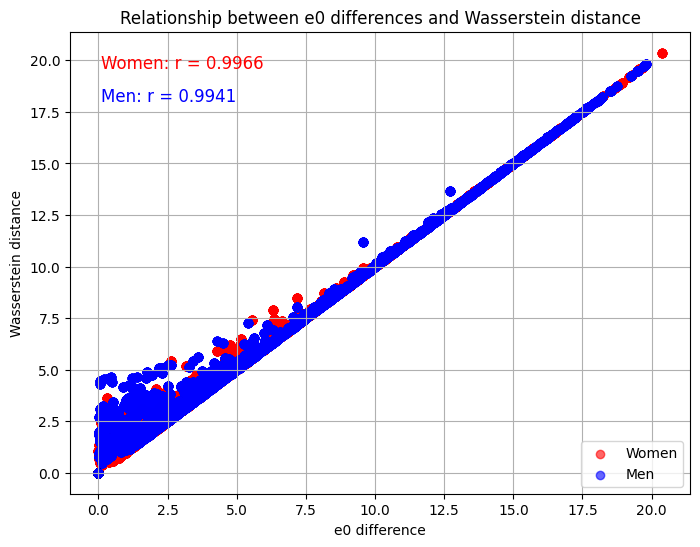

In [59]:
plt.figure(figsize=(8,6))

for sex, color in zip(["Women", "Men"], ["red", "blue"]):
    subset = final_df_cohort[final_df_cohort["Sex"] == sex]
    plt.scatter(subset["e0_Diff"], subset["Wasserstein"], alpha=0.6, label=sex, color=color)
    
    r, _ = pearsonr(subset["e0_Diff"], subset["Wasserstein"])
    
    plt.text(
        0.05, 
        0.95 - (0.07 if sex == "Men" else 0), 
        f"{sex}: r = {r:.4f}", 
        transform=plt.gca().transAxes,
        fontsize=12,
        color=color,
        verticalalignment="top"
    )

plt.xlabel("e0 difference")
plt.ylabel("Wasserstein distance")
plt.title("Relationship between e0 differences and Wasserstein distance")
plt.legend()
plt.grid(True)
plt.show()

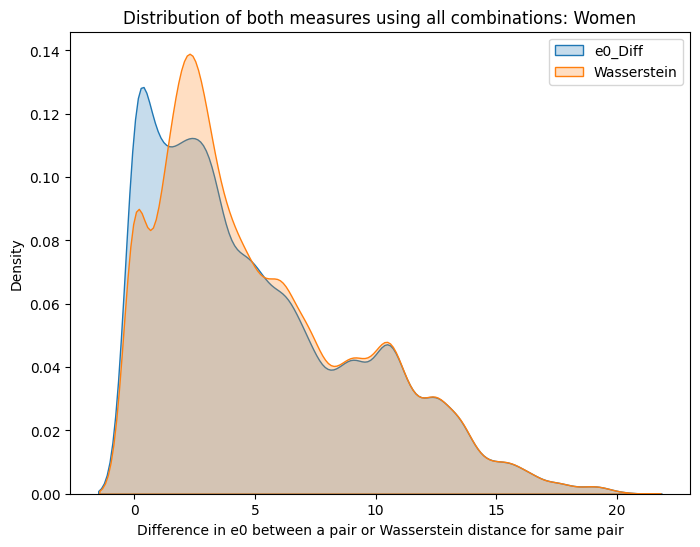

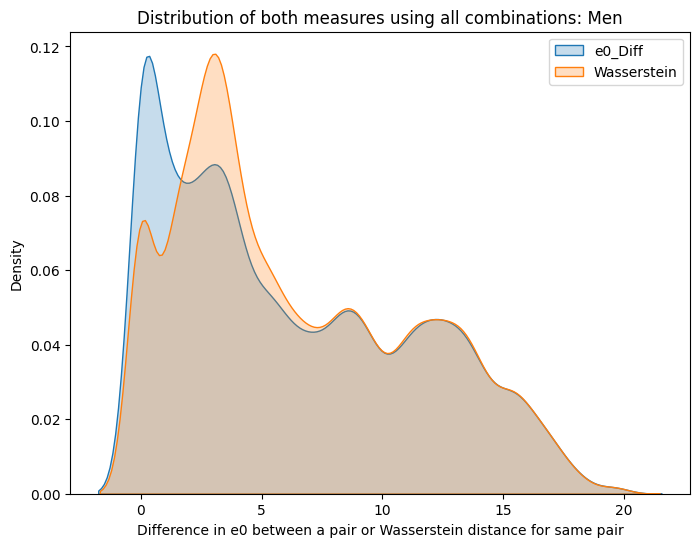

In [60]:
import seaborn as sns
for sex in ["Women", "Men"]:
    subset = final_df_cohort[final_df_cohort["Sex"] == sex]
    plt.figure(figsize=(8,6))

    sns.kdeplot(subset["e0_Diff"], label="e0_Diff", fill=True)
    sns.kdeplot(subset["Wasserstein"], label="Wasserstein", fill=True)

    plt.title(f"Distribution of both measures using all combinations: {sex}")
    plt.xlabel("Difference in e0 between a pair or Wasserstein distance for same pair")
    plt.legend()
    plt.show()

In [61]:
summary = (
    final_df_cohort
    .groupby("Sex")[["Wasserstein", "e0_Diff"]]
    .agg(["min", "mean", "max"])
    .round(2)
)


summary.columns = [f"{col}_{stat}" for col, stat in summary.columns]
print(summary.reset_index())

     Sex  Wasserstein_min  Wasserstein_mean  Wasserstein_max  e0_Diff_min  \
0    Men              0.0              6.50            19.81         0.00   
1  Women              0.0              5.29            20.37        -0.01   

   e0_Diff_mean  e0_Diff_max  
0          6.24        19.81  
1          5.12        20.37  


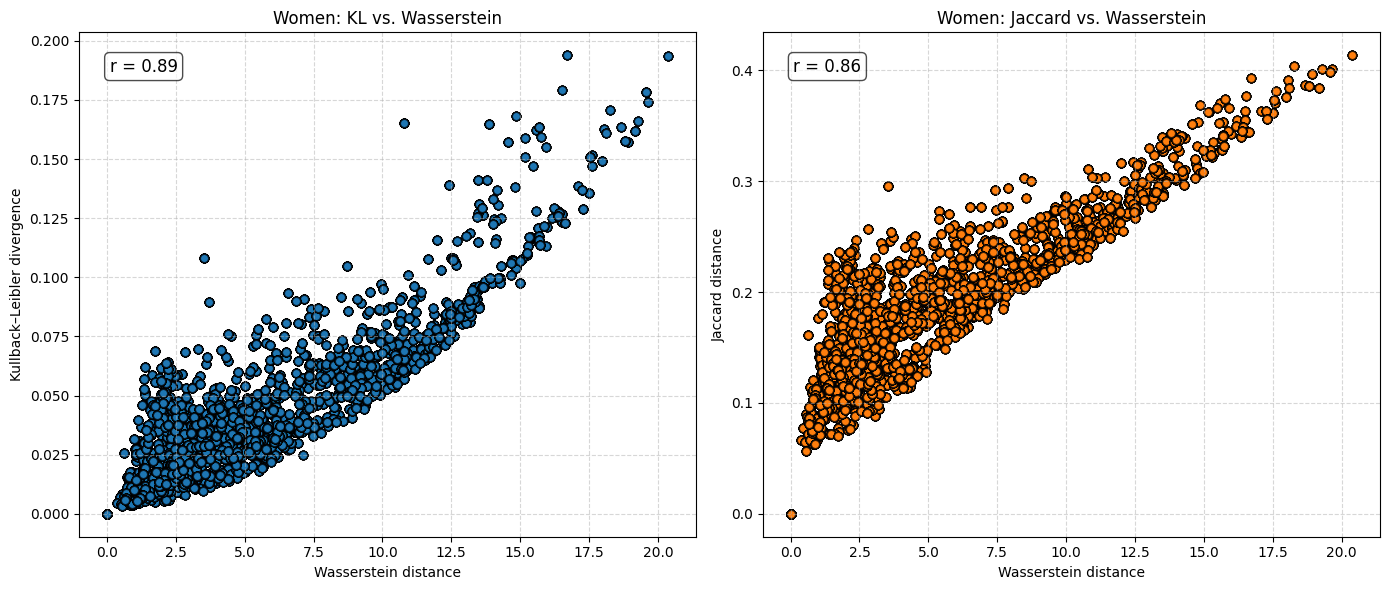

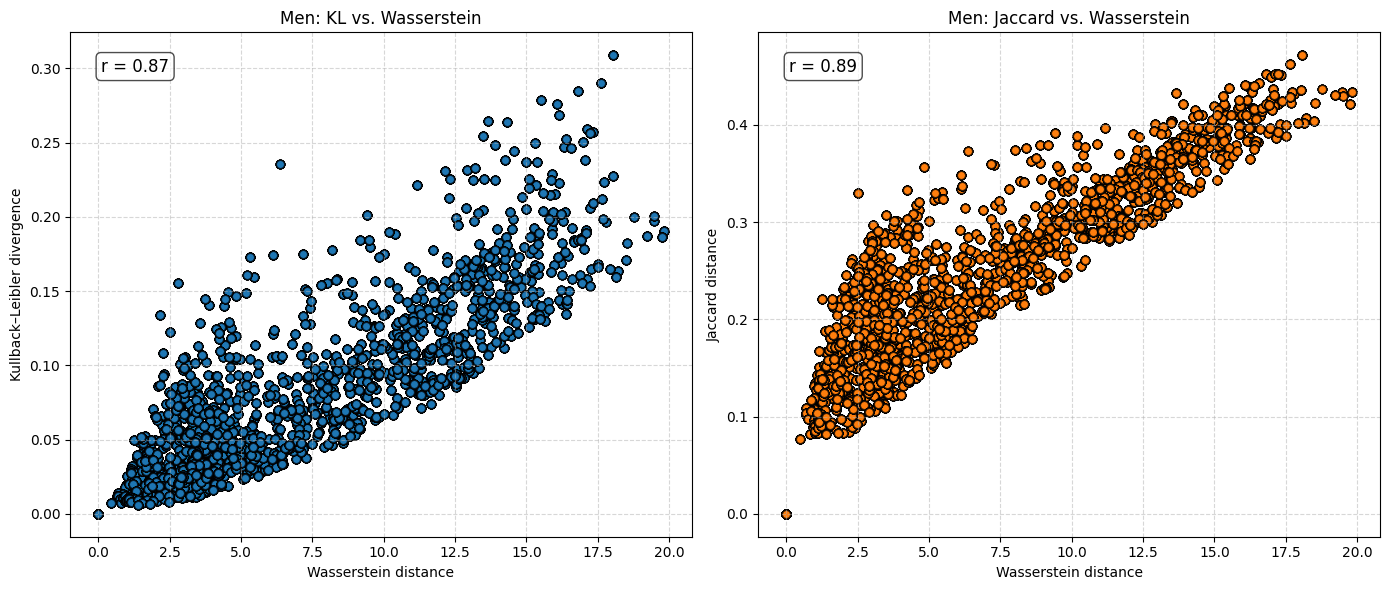

In [62]:
# Loop over sexes
for sex in ["Women", "Men"]:
    df_sex = final_df_cohort[final_df_cohort["Sex"] == sex]
    if df_sex.empty:
        continue

    # Pearson correlations
    r_kl, _ = pearsonr(df_sex["Wasserstein"], df_sex["KL_divergence"])
    r_jaccard, _ = pearsonr(df_sex["Wasserstein"], df_sex["Jaccard_distance"])

    # Make two side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Plot 1: KL vs Wasserstein ---
    axes[0].scatter(df_sex["Wasserstein"], df_sex["KL_divergence"],
                    alpha=0.6, edgecolor="k")
    axes[0].set_xlabel("Wasserstein distance")
    axes[0].set_ylabel("Kullback–Leibler divergence")
    axes[0].set_title(f"{sex}: KL vs. Wasserstein")
    axes[0].grid(True, linestyle="--", alpha=0.5)
    axes[0].text(0.05, 0.95, f"r = {r_kl:.2f}",
                 transform=axes[0].transAxes,
                 fontsize=12, verticalalignment="top",
                 bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # --- Plot 2: Jaccard vs Wasserstein ---
    axes[1].scatter(df_sex["Wasserstein"], df_sex["Jaccard_distance"],
                    alpha=0.6, edgecolor="k", color="tab:orange")
    axes[1].set_xlabel("Wasserstein distance")
    axes[1].set_ylabel("Jaccard distance")
    axes[1].set_title(f"{sex}: Jaccard vs. Wasserstein")
    axes[1].grid(True, linestyle="--", alpha=0.5)
    axes[1].text(0.05, 0.95, f"r = {r_jaccard:.2f}",
                 transform=axes[1].transAxes,
                 fontsize=12, verticalalignment="top",
                 bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    plt.tight_layout()
    plt.show()

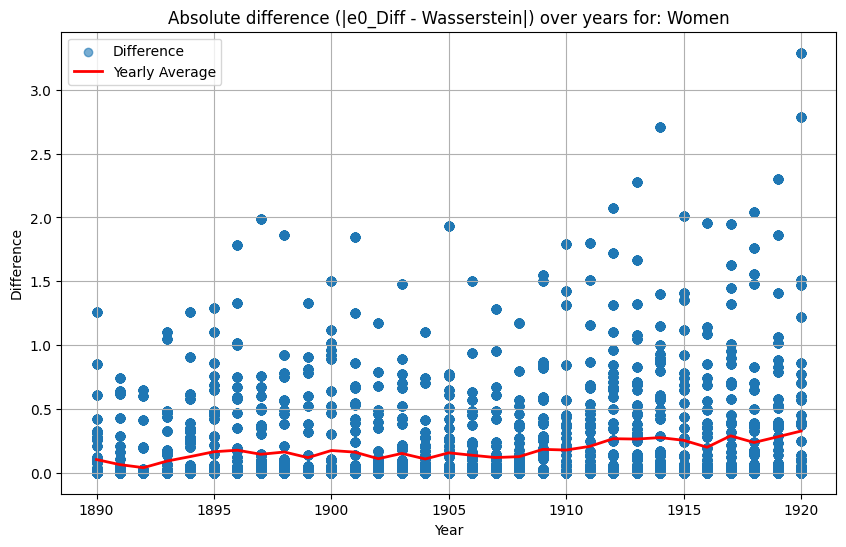

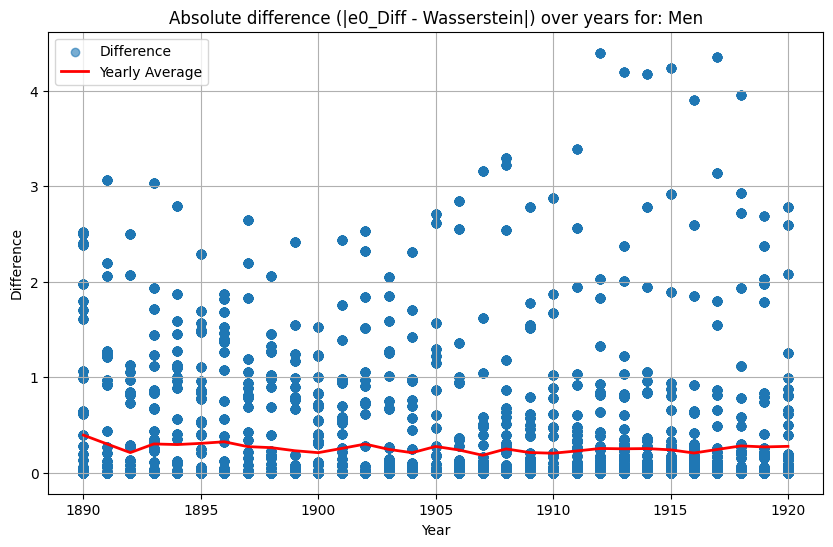

In [63]:
final_df_cohort["e0_Diff"] = pd.to_numeric(final_df_cohort["e0_Diff"], errors='coerce')
final_df_cohort["Wasserstein"] = pd.to_numeric(final_df_cohort["Wasserstein"], errors='coerce')

final_df_cohort["Diff_e0_Wasserstein"] = abs(final_df_cohort["e0_Diff"] - final_df_cohort["Wasserstein"])

for sex in ["Women", "Men"]:
    df_sex = final_df_cohort[final_df_cohort["Sex"] == sex]

    yearly_avg = df_sex.groupby("Year")["Diff_e0_Wasserstein"].mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.scatter(df_sex["Year"], df_sex["Diff_e0_Wasserstein"], alpha=0.6, label="Difference")
    plt.plot(yearly_avg["Year"], yearly_avg["Diff_e0_Wasserstein"], color="red", linewidth=2, label="Yearly Average")
    plt.title(f"Absolute difference (|e0_Diff - Wasserstein|) over years for: {sex}")
    plt.xlabel("Year")
    plt.ylabel("Difference")
    plt.grid(True)
    plt.legend()
    plt.show()

In [64]:
final_df_cohort["diff_abs"] = (final_df_cohort["e0_Diff"] - final_df_cohort["Wasserstein"]).abs()
threshold = final_df_cohort["diff_abs"].quantile(0.95)

interesting_cases = final_df_cohort[final_df_cohort["diff_abs"] >= threshold]
df_sorted = interesting_cases.sort_values(by='diff_abs', ascending=False)
print(df_sorted)

      CountryA CountryB  Year  Sex  e_0_CountryA  e_0_CountryB  e0_Diff  \
65756      FIN      ESP  1912  Men     47.676254     47.635553     0.04   
65757      FIN      ESP  1912  Men     47.676254     47.635553     0.04   
65752      FIN      ESP  1912  Men     47.676254     47.635553     0.04   
65750      FIN      ESP  1912  Men     47.676254     47.635553     0.04   
65753      FIN      ESP  1912  Men     47.676254     47.635553     0.04   
...        ...      ...   ...  ...           ...           ...      ...   
50863      NOR      DNK  1891  Men     53.576853     53.203931     0.37   
50864      NOR      DNK  1891  Men     53.576853     53.203931     0.37   
50865      NOR      DNK  1891  Men     53.576853     53.203931     0.37   
50866      NOR      DNK  1891  Men     53.576853     53.203931     0.37   
50867      NOR      DNK  1891  Men     53.576853     53.203931     0.37   

       Wasserstein  KL_divergence  Jaccard_distance Condition  YearA  YearB  \
65756         4.44  